# 1. LSST generator single-band

We use the Lenstronomi API $\texttt{Simulation}$ to emulate the conditions of LSST. But this time working with one single band, the $g$ band.


In [22]:
# Instrument setting from pre-defined configurations

# from lenstronomy.SimulationAPI.ObservationConfig.DES import DES
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST


# We instantiate LSST configurations for the g, r, i bands
# We use a Gaussian PSF and assume 10 years of image coaddition (full survey)
LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=10)
LSST_i = LSST(band='i', psf_type='GAUSSIAN', coadd_years=10)
# lsst = [LSST_g, LSST_r, LSST_i]  # We group the LSST configurations

In [23]:
# We extract the configurations for that band
kwargs_band = LSST_g.kwargs_single_band()

The astrophysical components system of the simulation.

Lens Mass Model: Singular Isothermal Ellipsoid (for the main lens) + External shear

$$\mathbf{\text{SIE}} + \mathbf{\text{SHEAR}}$$

Source Light Model: Elliptical Sérsic profile.
$$\mathbf{\text{SERSIC\_ELLIPSE}}$$

We are not using Lens Light or Point Source.



In [24]:
# Models used for the lens, source, and other components
kwargs_model = {
    'lens_model_list': ['SIE', 'SHEAR'],
    'source_light_model_list': ['SERSIC_ELLIPSE'],
    'lens_light_model_list': [],
    'point_source_model_list': []
}

In [25]:
# Required arguments for the lens models mentioned above
kwargs_lens = [
    {
        'theta_E': 1.2,       # Einstein radius in arcsec
        'e1': 0.4, 'e2': -0.1,  # ellipticity (quadrupole components)
        'center_x': 0, 'center_y': 0  # lens position
    },
    {
        'gamma1': 0.03, 'gamma2': 0.01,  # magnitude and orientation of the external shear
        'ra_0': 0, 'dec_0': 0            # reference center for the shear
    }
]

In [26]:
# Arguments for the source light
kwargs_source_mag = [{
    'magnitude': 21,
    'R_sersic': 0.4,
    'n_sersic': 1,
    'e1': 0.05,
    'e2': -0.05,
    'center_x': 0.1,
    'center_y': 0.05
}]

This block generates and displays the simulated strong lens image

1. Initializes $\mathbf{\text{SimAPI}}$
2. Converts $\mathbf{\text{magnitudes}}$ to $\mathbf{\text{amplitudes}}$
3. Generates the noiseless $\mathbf{\text{image}}$, and adds $\mathbf{\text{noise}}$.Result: 

The final image is shown with a $\textbf{square-root stretch}$.

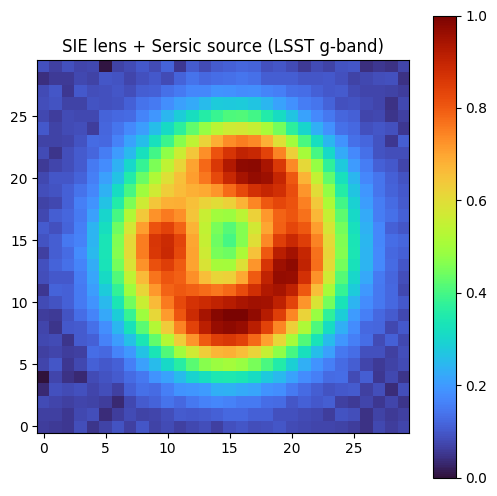

In [27]:
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Plots import plot_util
import matplotlib.pyplot as plt

# resolution
size = 6.0  # arcsec
pixel_scale = kwargs_band['pixel_scale']
numpix = int(round(size / pixel_scale))

# create simulator
sim = SimAPI(numpix=numpix, kwargs_single_band=kwargs_band, kwargs_model=kwargs_model)

# convert magnitudes to amplitudes
_, kwargs_source, _ = sim.magnitude2amplitude([], kwargs_source_mag, [])

# image model
kwargs_numerics = {'point_source_supersampling_factor': 1}
imSim = sim.image_model_class(kwargs_numerics)

# generate image
image = imSim.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_source,
                    kwargs_lens_light=None, kwargs_ps=None)

# add noise
image += sim.noise_for_model(image)

# display
plt.figure(figsize=(6,6))
plt.imshow(plot_util.sqrt(image), origin='lower', cmap='turbo')
plt.title('SIE lens + Sersic source (LSST g-band)')
plt.colorbar()
plt.show()

#### Now the system we are been using all this time

In [28]:
from astropy import units as u
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM
import numpy as np
from lenstronomy.Util.param_util import phi_q2_ellipticity, shear_polar2cartesian

In [29]:
#Cosmological parameters
z_lens, z_source = 0.881, 2.059
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.048)
D_d  = cosmo.angular_diameter_distance(z_lens)
D_s  = cosmo.angular_diameter_distance(z_source)
D_ds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

In [30]:
#LSST bands 
LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
#Parameters for that single band
kwargs_band = LSST_g.kwargs_single_band()

In [31]:
#Models used for the lens, source and other components for the subhalo case
kwargs_model_sub= {
    'lens_model_list': ['EPL', 'SIS', 'SHEAR_REDUCED'],
    'source_light_model_list': ['SERSIC_ELLIPSE']
}

#Kwards for the model without subhalo
kwargs_model_nosub= {
    'lens_model_list': ['EPL', 'SHEAR_REDUCED'],
    'source_light_model_list': ['SERSIC_ELLIPSE']
}

In [32]:
#Now the parameters for every model

##subhalo parameters, for an isothermal sphere (SIS) profile
mass_subhalo = 1e9  # Mass of the subhalo in solar masses
position_subhalo = [0.0,1.3]  # Position of the subhalo in arcseconds

M_sub = mass_subhalo * u.M_sun  # Masa del subhalo
# Cálculo del radio de Einstein del subhalo en radianes
thetaE_sub_rad = np.sqrt(4*G*M_sub/c**2 * (D_ds/(D_d*D_s)))
# Conversión del radio de Einstein a arcosegundos
thetaE_sub = (thetaE_sub_rad * u.rad).to(u.arcsec).value
kwargs_sub = {'theta_E': thetaE_sub, 
'center_x': position_subhalo[0], 
'center_y': position_subhalo[1]} 

##kwargs for the main lens model

#Einstein radius and the gamma and gamma
theta_E_main, gamma_main = 1.452, 1.9
e1_main, e2_main = phi_q2_ellipticity(phi=np.deg2rad(-22.29), q=0.866)  # Elipticidad de la lente principal
kwargs_main = {
    'theta_E': theta_E_main, 'gamma': gamma_main,
    'e1': e1_main, 'e2': e2_main,
    'center_x': 0.0, 'center_y': -0.1  # Centro de la lente principal
} 

## shear reduced parameters
g1, g2 = shear_polar2cartesian(phi=np.deg2rad(107.9), gamma=0.015)  # Conversión de cizalla polar a cartesiana
kwargs_shear = {'gamma1': g1, 'gamma2': g2}

#Now we group the kwargs for both cases
kwargs_lens_sub = [kwargs_main, kwargs_sub, kwargs_shear]
kwargs_lens_nosub = [kwargs_main, kwargs_shear]


In [33]:
#Now the parameters for the source light, is the same for both cases
kwargs_source_mag = [{
    'magnitude': 21,
    'R_sersic': 0.4,
    'n_sersic': 1,
    'e1': 0.05,
    'e2': -0.05,
    'center_x': 0.1,
    'center_y': 0.05
}]

In [34]:
#Resolution and grid
size = 6.0  # arcsec
pixel_scale = kwargs_band['pixel_scale']
numpix = int(round(size / pixel_scale))

In [35]:
#Simulator for the models

# sim subhalo
sim_sub = SimAPI(numpix=numpix, 
             kwargs_single_band=kwargs_band, 
             kwargs_model=kwargs_model_sub)
#nosubhalo
sim_nosub = SimAPI(numpix=numpix, 
             kwargs_single_band=kwargs_band, 
             kwargs_model=kwargs_model_nosub)


In [36]:
#Convert magnitudes to amplitudes
_, kwargs_source_sub, _ = sim_sub.magnitude2amplitude([], kwargs_source_mag, [])
_, kwargs_source_nosub, _ = sim_nosub.magnitude2amplitude([], kwargs_source_mag, [])    

In [37]:
# numeric settings for subhalo case
kwargs_numerics = {'point_source_supersampling_factor': 1}
imSim_sub = sim_sub.image_model_class(kwargs_numerics)
imSim_nosub = sim_nosub.image_model_class(kwargs_numerics)

In [38]:
#Now we generate the images for both cases
#Image with subhalo
# generar imagen
image_sub = imSim_sub.image(kwargs_lens=kwargs_lens_sub, kwargs_source=kwargs_source,
                    kwargs_lens_light=None, kwargs_ps=None)

image_nosub = imSim_nosub.image(kwargs_lens=kwargs_lens_nosub, kwargs_source=kwargs_source,
                    kwargs_lens_light=None, kwargs_ps=None)

# add noise
image_nosub_nonoise = image_nosub.copy()
image_sub += sim.noise_for_model(image_sub)
image_nosub += sim.noise_for_model(image_nosub)


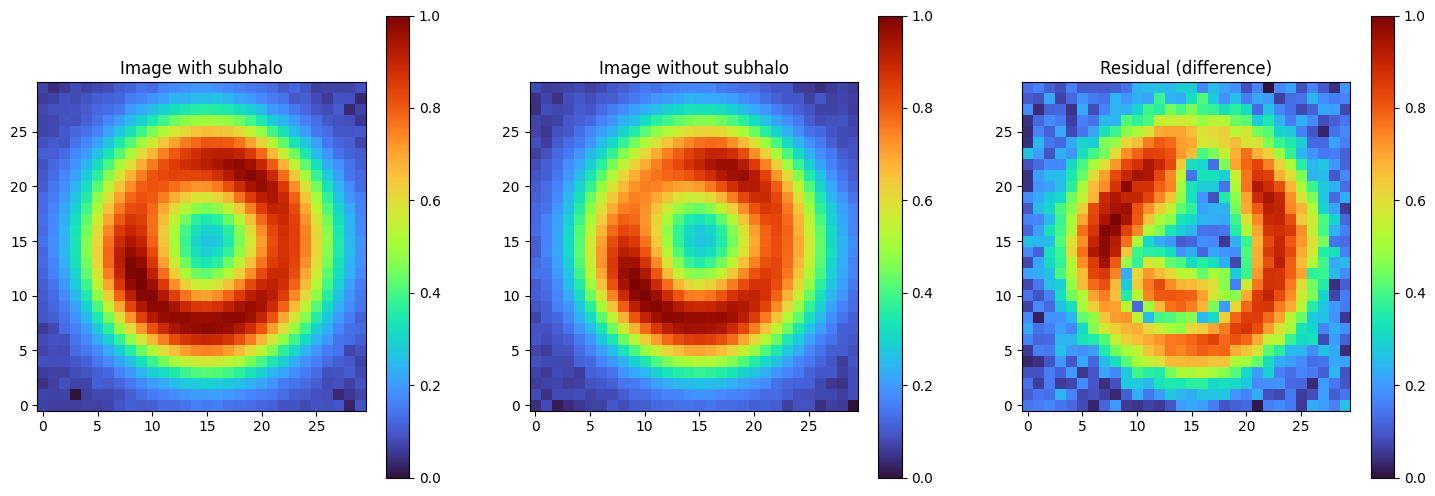

In [39]:
#now we plot both images side by side and the residual
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(plot_util.sqrt(image_sub), origin='lower', cmap='turbo')
plt.title('Image with subhalo')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(plot_util.sqrt(image_nosub), origin='lower', cmap='turbo')      
plt.title('Image without subhalo')
plt.colorbar()
plt.subplot(1,3,3)
image_diff = image_sub - image_nosub
plt.imshow(plot_util.sqrt(np.abs(image_diff)), origin='lower', cmap='turbo')    
plt.title('Residual (difference)')
plt.colorbar()
plt.show()

**This square-root stretch was applied in the previous version of my code, and now I understand that its purpose is more for visual effect than for accurately representing LSST observables. So now I'm no longer applying it...**

Here the lens image without that transformation:

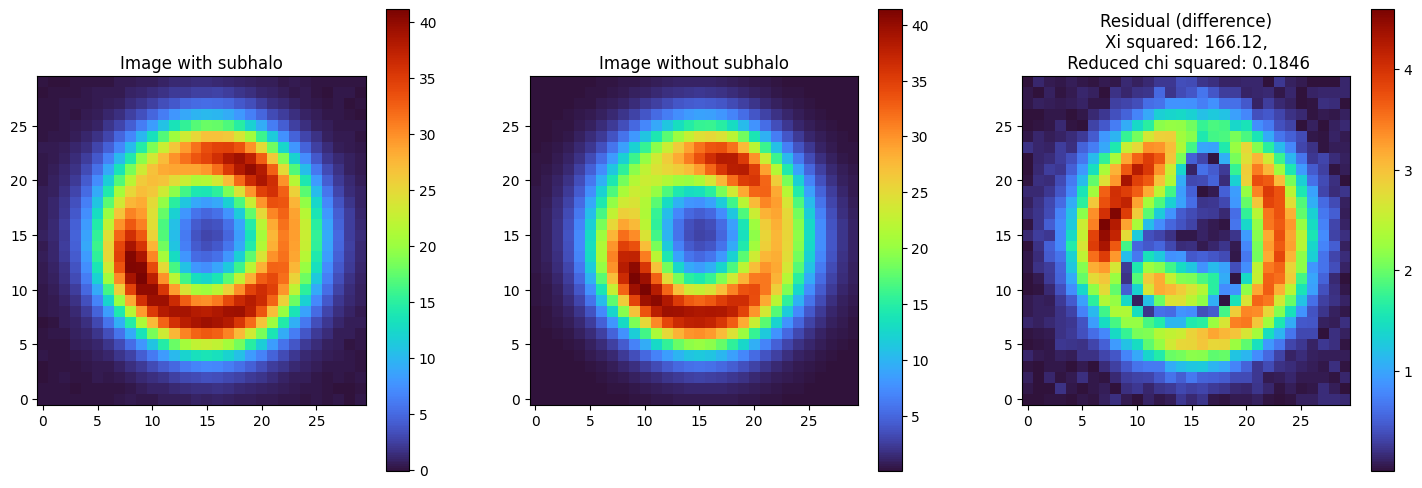

In [40]:
#now we plot both images side by side and the residual
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(image_sub, origin='lower', cmap='turbo')
plt.title('Image with subhalo')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(image_nosub_nonoise, origin='lower', cmap='turbo')      
plt.title('Image without subhalo')
plt.colorbar()
plt.subplot(1,3,3)
image_diff = image_sub - image_nosub_nonoise
plt.imshow(np.abs(image_diff), origin='lower', cmap='turbo')    
plt.title('Residual (difference)')
plt.colorbar()
#We add the xi squared in the title
xi_squared = np.sum(((image_sub - image_nosub_nonoise) ** 2) / (image_nosub_nonoise + 1e-6))  # Adding a small value to avoid division by zero
#and the reduced chi squared
ndof = np.sum(image_nosub_nonoise > 1e-6)  # Number of degrees of freedom
chi_squared_reduced = xi_squared / ndof
plt.title(f'Residual (difference)\nXi squared: {xi_squared:.2f},\n Reduced chi squared: {chi_squared_reduced:.4f}')

#change the scale to arsecseconds
plt.show()

This block calculates and prints the $\chi^2$ (chi-squared) and reduced $\chi^2$ (chi-squared) values to quantify the difference between two simulated images: $\mathbf{\text{image\_sub}}$ (with a subhalo perturbation) and $\mathbf{\text{image\_nosub}}$ (the unperturbed image).$\chi^2$ Calculation:$$\mathbf{\chi^2 = \sum \frac{(\text{image\_sub} - \text{image\_nosub})^2}{\text{image\_nosub}}}$$Reduced $\chi^2$: Divides $\mathbf{\chi^2}$ by the number of degrees of freedom ($\mathbf{\text{ndof}}$), defined as the number of non-zero pixels in $\mathbf{\text{image\_nosub}}$.

In [41]:
#Now we compute the xi squared between both images
# Compute xi squared
xi_squared = np.sum(((image_sub - image_nosub) ** 2) / (image_nosub + 1e-6))  # Adding a small value to avoid division by zero
print(f'Xi squared between images with and without subhalo: {xi_squared}')   
#and the reduced chi squared
ndof = np.sum(image_nosub > 1e-6)  # Number of degrees of freedom
chi_squared_reduced = xi_squared / ndof
print(f'Reduced chi squared between images with and without subhalo: {chi_squared_reduced}')  

Xi squared between images with and without subhalo: 177.60410954777794
Reduced chi squared between images with and without subhalo: 0.20390827732236272


This block calculates the standard pixel-wise $\chi^2$ (chi-squared) and reduced $\chi^2$ values to quantify the difference between the image with the perturbation ($\mathbf{\text{image\_sub}}$) and the noiseless, unperturbed model ($\mathbf{\text{image\_nosub\_nonoise}}$).

Noise Estimation: $\mathbf{\text{noise\_map}}$ is calculated from $\mathbf{\text{image\_sub}}$ using $\mathbf{\text{sim.estimate\_noise}}$.$\chi^2$ Calculation: The difference between the images is normalized (weighted) by the square of the noise map, $\mathbf{\text{noise\_map}}^2$:$$\mathbf{\chi^2 = \sum \frac{(\text{image}_{\text{sub}} - \text{image}_{\text{nosub\_nonoise}})^2}{\text{noise\_map}^2}}$$Reduced $\chi^2$: This is $\mathbf{\chi^2}$ divided by the number of degrees of freedom ($\mathbf{\text{ndof}}$), calculated as the number of finite pixels in the noiseless model.

In [45]:
# compute the model and its noise
noise_map = sim.estimate_noise(image_sub)

# chi² (or ξ²) pixel-wise
xi_squared = np.sum(((image_sub - image_nosub_nonoise)**2) / (noise_map**2 + 1e-12))

# reduced chi²
ndof = np.sum(np.isfinite(image_nosub_nonoise))
xi_squared_red = xi_squared / ndof
print(f'Pixel-wise Xi squared: {xi_squared}, Reduced Xi squared: {xi_squared_red}')


Pixel-wise Xi squared: 174465.60086827033, Reduced Xi squared: 193.85066763141148


This block calculates the $\chi^2$ and reduced $\chi^2$ values, but this time using the square-root of the images ($\mathbf{\text{sqrt\_image\_sub}}$ and $\mathbf{\text{sqrt\_image\_nosub}}$), a common transformation to stabilize variance in astrophysical images.$\chi^2$ Calculation: The difference between the square-rooted images is weighted by the square of the $\mathbf{\text{noise map}}$, $\mathbf{\text{noise\_map}}^2$:$$\mathbf{\chi^2_{\text{sqrt}} = \sum \frac{(\sqrt{\text{Image}_{\text{sub}}} - \sqrt{\text{Image}_{\text{nosub}}})^2}{\text{noise\_map}^2}}$$Reduced $\chi^2$: This is $\mathbf{\chi^2_{\text{sqrt}}}$ divided by the degrees of freedom ($\mathbf{\text{ndof}_{\text{sqrt}}}$).

In [46]:
sqrt_image_sub = plot_util.sqrt(image_sub)
sqrt_image_nosub = plot_util.sqrt(image_nosub_nonoise)

xi_squared_sqrt = np.sum(((sqrt_image_sub - sqrt_image_nosub) ** 2) / (noise_map**2 + 1e-12))  # Adding a small value to avoid division by zero
print(f'Xi squared between sqrt images with and without subhalo: {xi_squared_sqrt}')
#and the reduced chi squared for the sqrt images
ndof_sqrt = np.sum(sqrt_image_nosub > 1e-6)  # Number of degrees of freedom
chi_squared_reduced_sqrt = xi_squared_sqrt / ndof_sqrt
print(f'Reduced chi squared between sqrt images with and without subhalo: {chi_squared_reduced_sqrt}')  

Xi squared between sqrt images with and without subhalo: 151.7617248966784
Reduced chi squared between sqrt images with and without subhalo: 0.16881170733779577


   1. ¿Qué hacer con las demás bandas?

   2. ¿Utilizar $\sqrt{Imagen}$

   3. Una vez hecho un nuevo clasificador basado en el $\chi^2_{reducido}$, cómo integrar un criterio bayesiano?

   4. $\mathcal{L} \sim \chi^2$

In [43]:
# #sacamos la transformada de fourier de ambas imágenes y comparamos sus espectros de potencia
# fft_image_sub = np.fft.fft2(image_sub)
# fft_image_nosub = np.fft.fft2(image_nosub)  
# power_spectrum_sub = np.abs(fft_image_sub)**2
# power_spectrum_nosub = np.abs(fft_image_nosub)**2
# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.imshow(np.fft.fftshift(np.log10(power_spectrum_sub + 1e-6)), origin='lower', cmap='turbo')
# plt.title('Power Spectrum with Subhalo')
# plt.colorbar()
# plt.subplot(1,2,2)
# plt.imshow(np.fft.fftshift(np.log10(power_spectrum_nosub +  1e-6)), origin='lower', cmap='turbo')
# plt.title('Power Spectrum without Subhalo')
# plt.colorbar()
# plt.show()  

In [44]:
# #and the difference between both power spectra
# power_spectrum_diff = np.abs(power_spectrum_sub - power_spectrum_nosub)
# plt.figure(figsize=(6,6))
# plt.imshow(np.fft.fftshift(np.log10(power_spectrum_diff + 1e-6)), origin='lower', cmap='turbo')
# plt.title('Difference in Power Spectra')
# plt.colorbar()
# plt.show()

In [47]:
# #now we compute the xi squared between both power spectra
# xi_squared_ps = np.sum(((power_spectrum_sub - power_spectrum_nosub) ** 2) / (power_spectrum_nosub + 1e-6))  # Adding a small value to avoid division by zero
# print(f'Xi squared between power spectra with and without subhalo: {xi_squared_ps}')

# #and the reduced chi squared
# ndof = np.sum(power_spectrum_nosub > 1e-6)  # Number of degrees of freedom
# chi_squared_reduced_ps = xi_squared_ps / ndof
# print(f'Reduced chi squared between power spectra with and without subhalo: {chi_squared_reduced_ps}')  